In [5]:
!pip install wandb


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [6]:
from model_class import *
from dataset_class import *

from collections import Counter
import torch
import numpy as np
import torchvision
import os
import wandb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE

In [7]:
torch.manual_seed(seed=2021555)
if torch.cuda.is_available():
    torch.cuda.manual_seed(2021555)
    torch.backends.cudnn.deterministic = True

CLASSES = ["amur_leopard" , "amur_tiger", "birds", "black_bear", "brown_bear",
            "dog", "roe_deer", "sika_deer", "wild_boar", "people"]
PATH = "/teamspace/studios/this_studio/HW1-Resources/data/russian-wildlife-dataset/Cropped_final"
BATCH_SIZE = 32 #ad1156ec378b22ea9e02c820cce1f9b837c049c4
wandb.login()

True

In [10]:
dataset = MyDataset(PATH)
labels = []

for _, label in dataset:
    labels.append(label.item())

In [11]:
train_idx, val_idx = train_test_split(range(len(dataset)), train_size = 0.8, test_size =0.2, stratify=labels, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle= True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle= True)

In [ ]:
val_labels = Counter()
train_labels = Counter()

for _, label in train_dataset:
    train_labels[int(label)] +=1

for _, label in val_dataset:
    val_labels[int(label)] +=1

In [ ]:
train_labels_sorted = sorted(train_labels.items())
val_labels_sorted = sorted(val_labels.items())

In [ ]:
print(val_labels)
print(train_labels)

Counter({7: 308, 2: 289, 8: 287, 5: 243, 4: 242, 6: 225, 1: 210, 0: 195, 3: 195, 9: 140})
Counter({7: 1231, 2: 1157, 8: 1148, 5: 970, 4: 967, 6: 899, 1: 839, 0: 783, 3: 780, 9: 560})


In [ ]:
train_list = []
train_count = []

val_list = []
val_count=[]

for label, count in train_labels_sorted:
    train_list.append(label)
    train_count.append(count)

for label, count in val_labels_sorted:
    val_list.append(label)
    val_count.append(count)

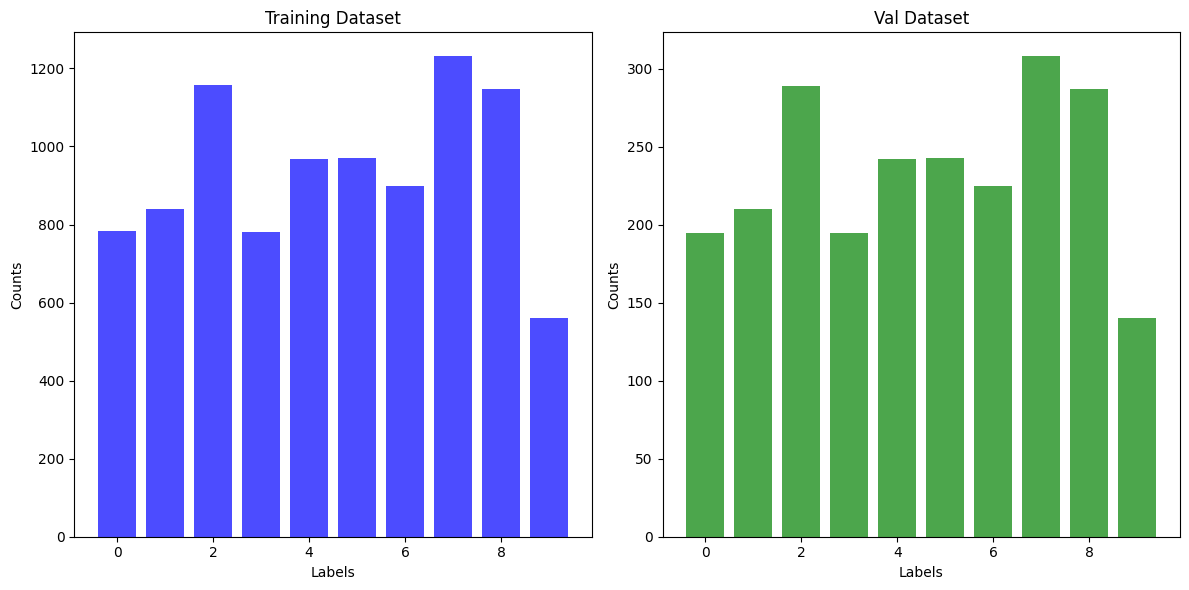

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(train_list, train_count, color='blue', alpha=0.7)
axes[0].set_title('Training Dataset')
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Counts')

axes[1].bar(val_list, val_count, color='green', alpha=0.7)
axes[1].set_title('Val Dataset')
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Counts')

plt.tight_layout()
plt.show()

In [13]:
wrong_image = []
wrong_label = []
wrong_pred = []


# Sources:
# 1. Referred this to understand how to edit the final layer of resnet: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
# 2. Use of identity: https://pytorch.org/docs/stable/generated/torch.nn.Identity.html?spm=5aebb161.2ef5001f.0.0.1fe7c921ETUq01
def feature_extract(model, loader, device):
  model.fc = torch.nn.Identity() # After training is complete, I have changed the final fully connected layer to identity which basically returns the output of the second last layer as it acts as a placeholder
  
  model.eval()
  inputs_list = []
  labels_list = []
  
  with torch.no_grad():
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      inputs_list.append(outputs.cpu())
      labels_list.append(labels.cpu())
      
  
  inputs_list = torch.cat(inputs_list, dim=0)
  labels_list = torch.cat(labels_list, dim=0)
  
  return inputs_list.numpy(), labels_list.numpy()
  

def train(model, train_loader, val_loader, num_epochs=10, lr=0.001, model_name=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    ce_loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if model_name == "cnn":
      wandb.init(project="CV_A1_cnn")
    elif model_name == "resnet":
      wandb.init(project="CV_A1_resnet")
    elif model_name == "resnet_aug":
      wandb.init(project="CV_A1_resnet_aug")

    best_val_acc = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        total_train = 0
        correct_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            model_outputs = model(inputs)
            loss = ce_loss(model_outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(model_outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train+= labels.size(0)

        avg_train_loss = train_loss / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        predictions = []
        true_labels = []

        with torch.no_grad():
            for inputs, labels, in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                model_outputs = model(inputs)

                val_loss += ce_loss(model_outputs, labels).item() * inputs.size(0)
                _, predicted = torch.max(model_outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

                if model_name=="cnn":
                  if epoch==num_epochs-1:
                    for i in range(len(labels)):
                      if(predicted[i]!=labels[i]):
                        wrong_image.append(inputs[i].cpu())
                        wrong_label.append(labels[i].cpu().item())
                        wrong_pred.append(predicted[i].cpu().item())

            avg_val_loss = val_loss / total_val

        train_acc = (correct_train/total_train)
        val_acc = (correct_val/total_val)
        f1 = f1_score(true_labels, predictions, average = "macro")
        
        if epoch == num_epochs-1 and model_name == "resnet":
          train_features, train_labels = feature_extract(model, train_loader, device)
          val_features, val_labels = feature_extract(model, val_loader, device)
          
          tsne_2d_train = TSNE(n_components=2)
          train_tsne_2d = tsne_2d_train.fit_transform(train_features)
          
          tsne_2d_val = TSNE(n_components=2)
          val_tsne_2d = tsne_2d_val.fit_transform(val_features)
          
          tsne_3d_val = TSNE(n_components=3)
          val_tsne_3d = tsne_3d_val.fit_transform(val_features)
          
          fig, axes = plt.subplots(3, 1, figsize=(6,18))
          
          axes[0].scatter(train_tsne_2d[:, 0], train_tsne_2d[:, 1], c=train_labels, alpha=0.8)
          axes[0].set_title("t-SNE 2D Train Set")
          axes[0].set_xlabel("Component 1")
          axes[0].set_ylabel("Component 2")
          
          axes[1].scatter(val_tsne_2d[:, 0], val_tsne_2d[:, 1], c=val_labels, alpha=0.8)
          axes[1].set_title("t-SNE 2D Validation Set")
          axes[1].set_xlabel("Component 1")
          axes[1].set_ylabel("Component 2")
          
          # Citations: 
          # 1. https://matplotlib.org/stable/api/_as_gen/matplotlib.figure.Figure.add_subplot.html
          # 2. https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
          ax3d = fig.add_subplot(313, projection="3d")  
          ax3d.scatter(val_tsne_3d[:, 0], val_tsne_3d[:, 1], val_tsne_3d[:, 2], c=val_labels, alpha=0.6)
          ax3d.set_title("t-SNE 3D Validation Set")
          ax3d.set_xlabel("Component 1")
          ax3d.set_ylabel("Component 2")
          ax3d.set_zlabel("Component 3")    
          
          plt.tight_layout()
          plt.show()      
          

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if model_name == "cnn":
              torch.save(model.state_dict(), "convnet.pth")
            elif model_name == "resnet":
              torch.save(model.state_dict(), "resnet.pth")
            elif model_name == "resnet_aug":
              torch.save(model.state_dict(), "resnet_aug.pth")

        print("Epoch:", epoch)

        wandb.log({"Train Loss": avg_train_loss, "Validation Loss": avg_val_loss, "Epoch": epoch})
        wandb.log({"Train Accuracy": train_acc, "Validation Accuracy": val_acc, "Epoch": epoch})
        wandb.log({"F1": f1, "Epoch": epoch})
        wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(probs=None, y_true=true_labels, preds=predictions, class_names=CLASSES), "Epoch": epoch})

    wandb.finish()



In [14]:
cnn_model = ConvNet(in_channels=3, num_classes=10)

train(cnn_model, train_loader, val_loader, num_epochs=10, lr=0.001, model_name="cnn")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


In [ ]:
idx_dict = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}


for i, label in enumerate(wrong_label):
    if len(idx_dict[label]) < 3:
      idx_dict[label].append(i)

idx_dict

{0: [1, 88, 94],
 1: [8, 17, 22],
 2: [0, 6, 34],
 3: [7, 16, 23],
 4: [2, 4, 11],
 5: [27, 37, 48],
 6: [13, 20, 54],
 7: [9, 10, 12],
 8: [15, 18, 33],
 9: [3, 5, 29]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Left Image
True Label:  0 Predicted:  2
Middle Image
True Label:  0 Predicted:  2
Right Image
True Label:  0 Predicted:  2


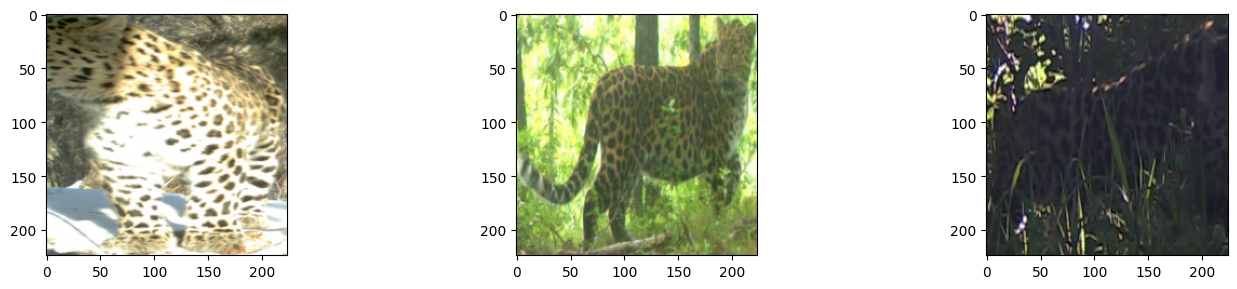

Left Image
True Label:  1 Predicted:  2
Middle Image
True Label:  1 Predicted:  0
Right Image
True Label:  1 Predicted:  0


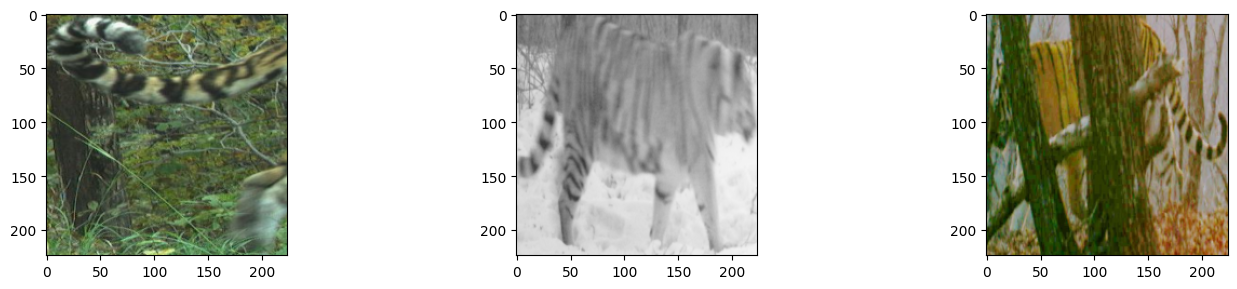

Left Image
True Label:  2 Predicted:  5
Middle Image
True Label:  2 Predicted:  5
Right Image
True Label:  2 Predicted:  5


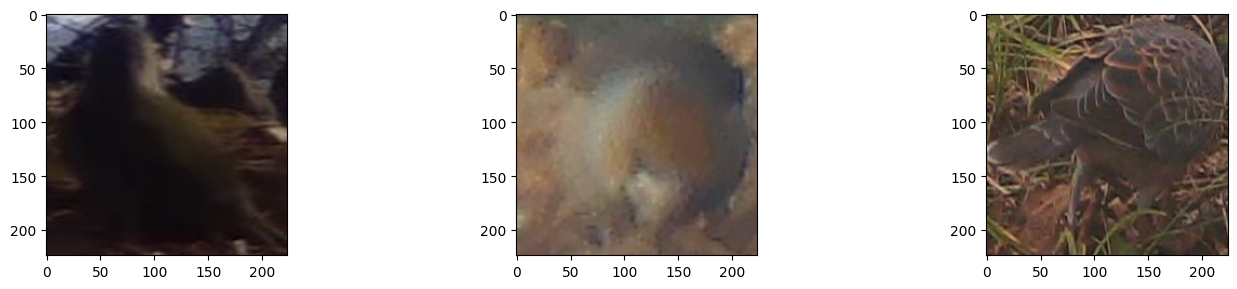

Left Image
True Label:  3 Predicted:  4
Middle Image
True Label:  3 Predicted:  9
Right Image
True Label:  3 Predicted:  5


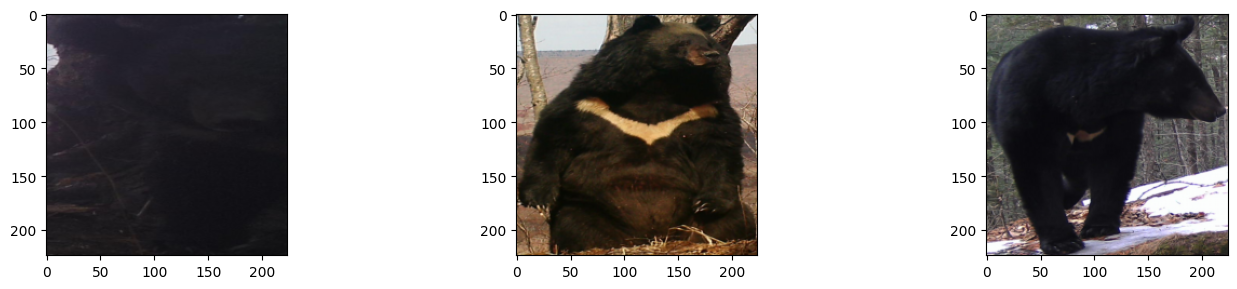

Left Image
True Label:  4 Predicted:  8
Middle Image
True Label:  4 Predicted:  8
Right Image
True Label:  4 Predicted:  7


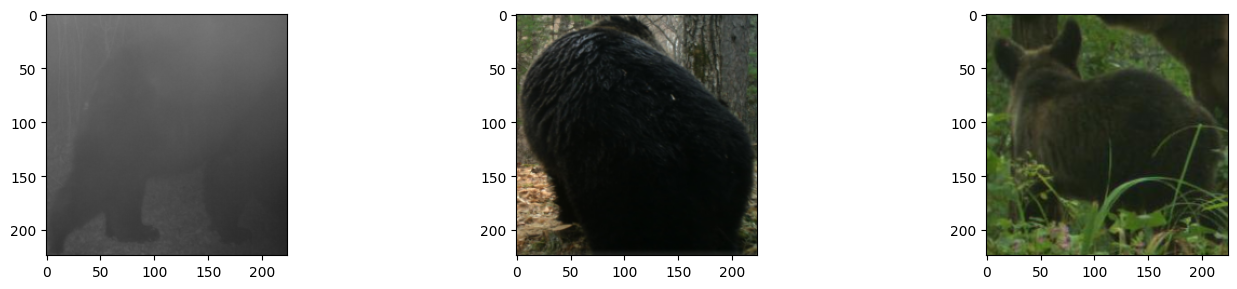

Left Image
True Label:  5 Predicted:  6
Middle Image
True Label:  5 Predicted:  4
Right Image
True Label:  5 Predicted:  1


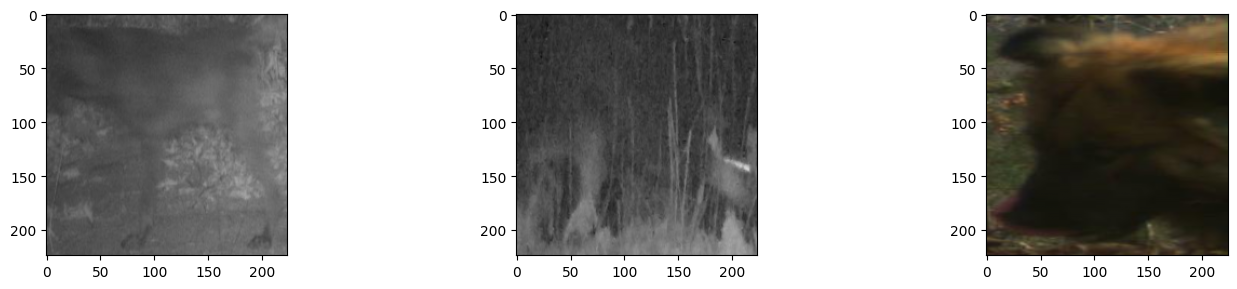

Left Image
True Label:  6 Predicted:  7
Middle Image
True Label:  6 Predicted:  5
Right Image
True Label:  6 Predicted:  5


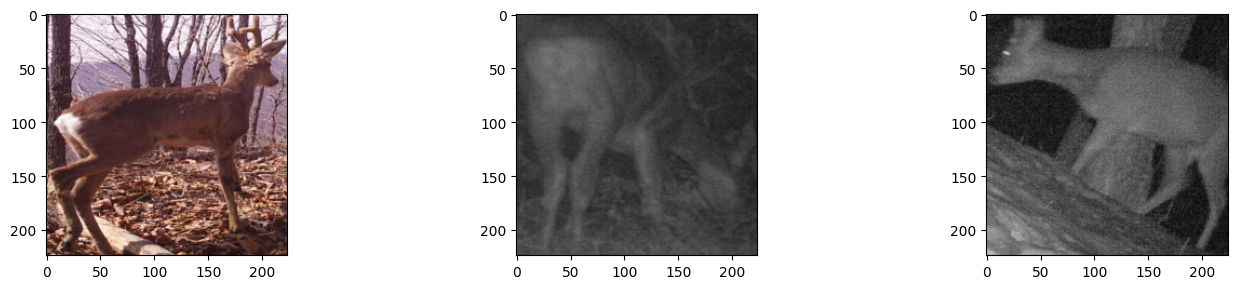

Left Image
True Label:  7 Predicted:  9
Middle Image
True Label:  7 Predicted:  8
Right Image
True Label:  7 Predicted:  5


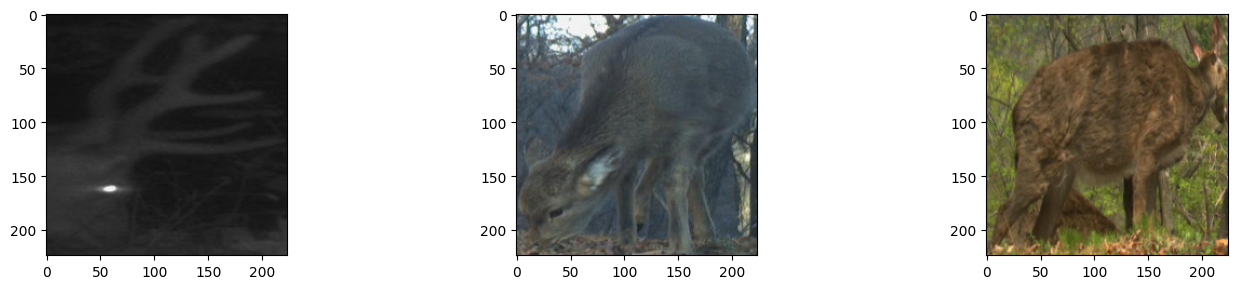

Left Image
True Label:  8 Predicted:  4
Middle Image
True Label:  8 Predicted:  1
Right Image
True Label:  8 Predicted:  4


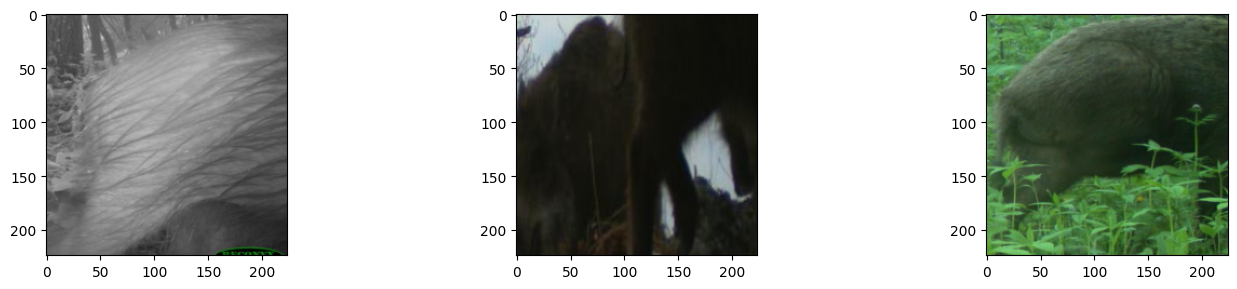

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Left Image
True Label:  9 Predicted:  7
Middle Image
True Label:  9 Predicted:  7
Right Image
True Label:  9 Predicted:  4


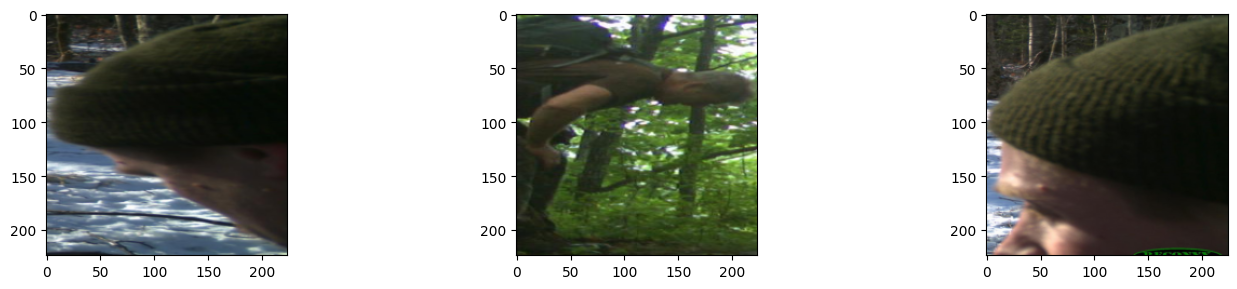

In [ ]:
for i in idx_dict.values():
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    for idx, j in enumerate(i):
        image = wrong_image[j].cpu()
        label = wrong_label[j]
        pred = wrong_pred[j]
        if idx == 0:
            print("Left Image")
        elif idx ==1:
            print("Middle Image")
        elif idx ==2:
            print("Right Image")
        
        print("True Label: ", label, "Predicted: ", pred)        
        image = image.permute(1, 2, 0)
        axes[idx].imshow(image)

    plt.tight_layout()
    plt.show()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8


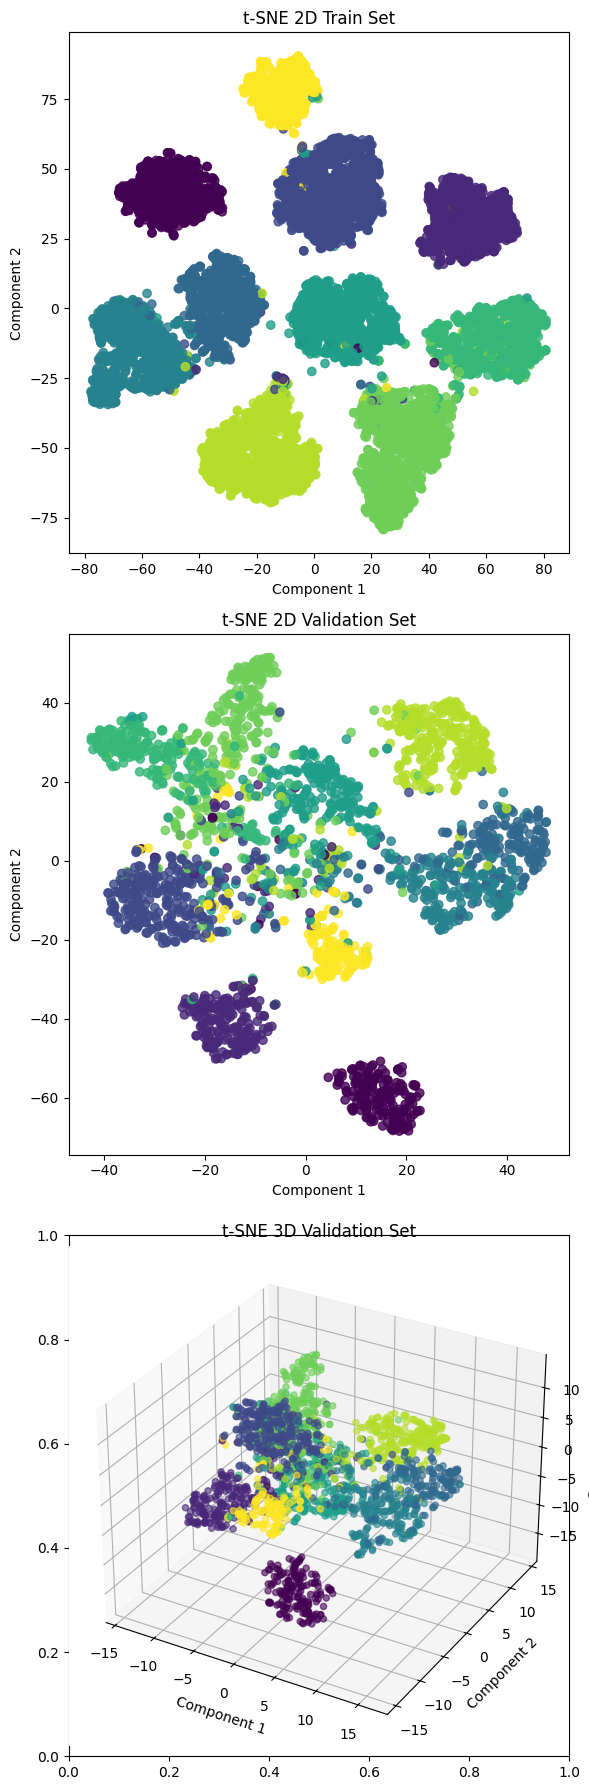

Epoch: 9


In [ ]:
resnet = ResNet18()
train(resnet, train_loader, val_loader, num_epochs=10, lr=0.001, model_name="resnet")

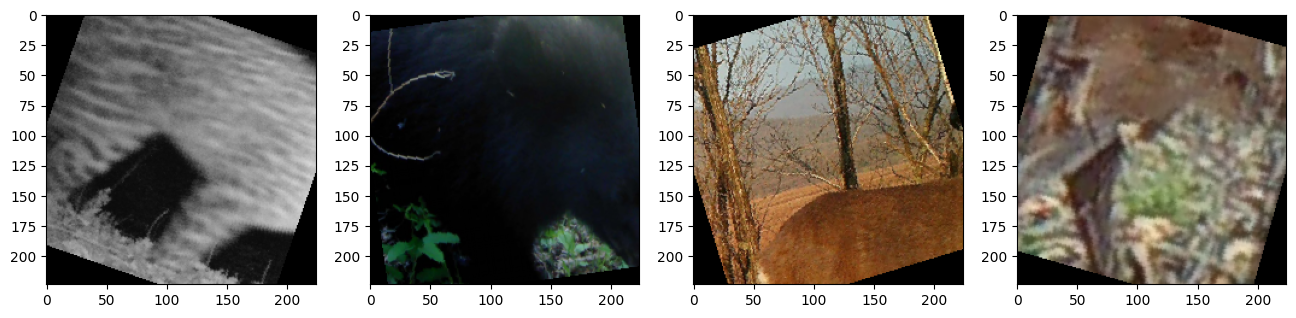

In [ ]:
aug_data = MyDataset(PATH, augment=True)

augmented_images = [aug_data[0], aug_data[4000], aug_data[8000], aug_data[10000]]
fig, axes = plt.subplots(1,4, figsize=(16,4))

for i in range(len(augmented_images)):
    image, _ = augmented_images[i]
    image = image.numpy()
    image = image.transpose(1,2,0)
    axes[i].imshow(image)


plt.show()

In [ ]:
train_dataset_aug = torch.utils.data.Subset(aug_data, train_idx)
train_dataset_aug = torch.utils.data.ConcatDataset([train_dataset, train_dataset_aug])

train_loader_aug = torch.utils.data.DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle= True)

In [ ]:
resnet = ResNet18()
train(resnet, train_loader_aug, val_loader, num_epochs=10, lr=0.001, model_name="resnet_aug")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
